In [1]:
import eeg_decoder 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
import scipy.stats as sista
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

np.random.seed(42)
%load_ext autoreload
%autoreload 2

C:\Users\William\AppData\Roaming\Python\Python38\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\William\AppData\Roaming\Python\Python38\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
output_dir = Path('./output')
fig_dir = output_dir / 'figures' / 'behavior'

behavior = None
experiment_name = 'e' 
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False)
    
for isub in range(2,exp.nsub):
    # Load subject's behavior data
    if behavior is None:
        behavior = pd.DataFrame(exp.load_behavior(isub))[['Subject','SetSize','BlockFeature','ACC','RT']]
    else:
        temp = pd.DataFrame(exp.load_behavior(isub))[['Subject','SetSize','BlockFeature','ACC','RT']]
        behavior = behavior.append(temp)

behavior.tail()

,Subject,SetSize,BlockFeature,ACC,RT
1063,10,2,1,1,797.952884
1064,10,2,1,0,1489.341903
1065,10,0,1,1,1006.207435
1066,10,1,1,1,1275.882321
1067,10,2,1,1,1106.648538


In [6]:
behavior = behavior.query('SetSize != 0')
total_means = behavior.groupby(['SetSize','BlockFeature'])['ACC'].mean().reset_index(drop=True)
subject_means = behavior.groupby(['SetSize','BlockFeature','Subject'])['ACC'].mean().reset_index()
subject_means['BlockFeature'] = subject_means['BlockFeature'].map({0:'Color',1:'Motion'})
total_means

0    0.988575
1    0.924565
2    0.983278
3    0.867014
Name: ACC, dtype: float64

In [7]:
subject_means.groupby(['Subject','SetSize','BlockFeature']).mean()

ACC
Subject SetSize BlockFeature          
3       1       Color         1.000000
                Motion        0.898649
        2       Color         0.984375
                Motion        0.848000
4       1       Color         1.000000
                Motion        0.888889
        2       Color         1.000000
                Motion        0.899038
5       1       Color         0.967033
                Motion        0.910714
        2       Color         0.930693
                Motion        0.830097
6       1       Color         1.000000
                Motion        0.938182
        2       Color         1.000000
                Motion        0.831461
7       1       Color         0.978814
                Motion        0.950207
        2       Color         0.991632
                Motion        0.903226
8       1       Color         0.983871
                Motion        0.904762
        2       Color         0.979592
                Motion        0.858369
10      1       Color         0.991561
                Motion        0.960159
        2       Color         0.991561
                Motion        0.890688

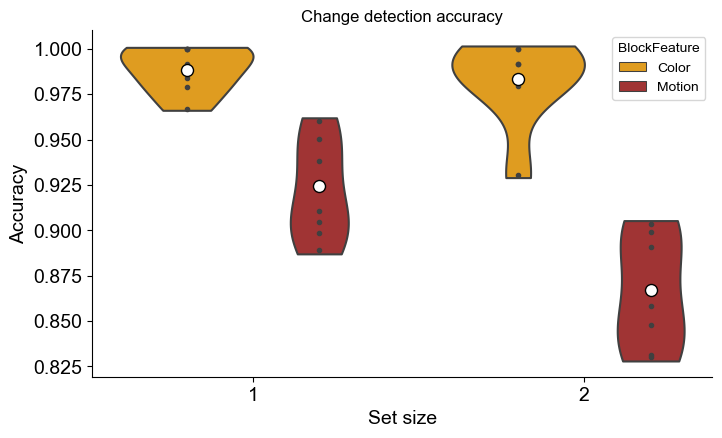

In [10]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,4.5))
my_pal = {"royalblue", "firebrick", "forestgreen", "orange"}

# experiment 1
sns.violinplot(
    ax = ax,
    x = 'SetSize',
    y = 'ACC',
    hue = 'BlockFeature',
    data = subject_means,
    dodge=True,
    inner='points',
    palette=my_pal,
    cut=.1
)
ax = plt.gca()
# plot means
ax.scatter(
    x = [-.2,.2,.8,1.2],
    y = [total_means[0],total_means[1],total_means[2],total_means[3]],
    c = 'white', edgecolors='k',s=75)

# asethetics
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.set_xlabel('Set size',fontsize=14)
ax.set_ylabel('Accuracy',fontsize=14)
ax.set_title('Change detection accuracy',)
plt.savefig('output/figures/cd_accuracy.png',dpi=500,bbox_inches='tight')
plt.savefig('output/figures/cd_accuracy.pdf',dpi=500,bbox_inches='tight')

plt.show()

# Accuracy ANOVA within each experiment

In [6]:
# model_exps = ols('ACC ~ C(SetSize) + C(Experiment) + C(Experiment*SetSize)', data=subject_means).fit();
# anova_table_exps = sm.stats.anova_lm(model_exps, typ=1);
# anova_table_exps


In [7]:
model_exp1 = ols('ACC ~ C(SetSize)', data=subject_means.loc[subject_means['Experiment']==0]).fit();
anova_table_exp1 = sm.stats.anova_lm(model_exp1, typ=1);
anova_table_exp1

,df,sum_sq,mean_sq,F,PR(>F)
C(SetSize),3.0,0.451782,0.150594,90.191793,2.015141e-31
Residual,128.0,0.213723,0.001670,NaN,NaN


In [8]:
model_exp2 = ols('ACC ~ C(SetSize)', data=subject_means.loc[subject_means['Experiment']==1]).fit();
anova_table_exp2 = sm.stats.anova_lm(model_exp2, typ=1);
anova_table_exp2

,df,sum_sq,mean_sq,F,PR(>F)
C(SetSize),3.0,0.788738,0.262913,32.927262,1.336688e-15
Residual,120.0,0.958158,0.007985,NaN,NaN


In [9]:
model_exp3 = ols('ACC ~ C(SetSize)', data=subject_means.loc[subject_means['Experiment']==2]).fit();
anova_table_exp3 = sm.stats.anova_lm(model_exp3, typ=1);
anova_table_exp3

,df,sum_sq,mean_sq,F,PR(>F)
C(SetSize),3.0,0.695943,0.231981,60.270951,4.766543e-20
Residual,76.0,0.292522,0.003849,NaN,NaN


# Timing

In [10]:
times = []
subs = []
exp = []
for iexp in [0,1,2]:
    df = behavior.loc[behavior.Experiment==iexp]
    for isub in np.unique(df['Subject']):
        df_sub = df.loc[df.Subject==isub]
        times.append((df_sub.iloc[-1]['Timestamp'] - df_sub.iloc[0]['Timestamp'])/60)
        subs.append(isub)
        exp.append(iexp)

In [11]:
print(np.mean(times))
print(min(times))
print(max(times))

105.07202380952383
73.05
132.45


# K


In [12]:
# Functions for calculating K from behavior
def calc_outcome(row):
    """
    calculate outcome of trial 
        hit: notice a change
        miss: fail to notice a change
        rej: notice there is no change
        fa (false alarm): notice change when there isn't one
    """
    accuracy = row['ACC']
    change = row['TrialType']
    if change == 1:
        if accuracy == 1:
            trial_outcome = 'hit'
        else:
            trial_outcome = 'miss'

    if change == 0:
        if accuracy == 1:
            trial_outcome = 'rej'
        else: 
            trial_outcome = 'fa'
    return trial_outcome

def _calc_k(outcome, change, ss):
    """
    a simple function that returns K.
    """
    
    hits = sum(outcome == 'hit')
    fa = sum(outcome == 'fa')

    num_change = sum(change==1)
    num_no_change = sum(change==0)

    h = hits/num_change
    f = fa/num_no_change
    k = ss*(h-f)
    return k

def calc_k(beh,ss):
    """
    Runs previous functions and returns subject K.
    """
    beh = beh[beh['SetSize']==ss]
    beh['outcome']=beh.apply(lambda row : calc_outcome(row), axis = 1)
    k = _calc_k(beh['outcome'],beh['TrialType'],ss)
    return k

In [13]:
%%capture
experiment_names = ['1801','1901','1902']
k = []
exps = []
ss = []
for iexp,experiment_name in enumerate(experiment_names):
    
    data_dir = f'./data/{experiment_name}'
    exp = decode_eeg.Experiment(experiment_name,data_dir,test=False)
    
    for isub in range(exp.nsub):
        # Load subject's behavior data
        behavior = pd.DataFrame(exp.load_behavior(isub))
        k.append(calc_k(behavior,1))
        k.append(calc_k(behavior,2))
        k.append(calc_k(behavior,3))
        k.append(calc_k(behavior,4))
    exps.append(np.repeat(iexp,exp.nsub*4))
    ss.append(np.tile([1,2,3,4],exp.nsub))

df = pd.DataFrame({'Experiment':np.concatenate(exps), 'Set size': np.concatenate(ss), 'K': k})

In [14]:
total_means = df.groupby(['Experiment','Set size'])['K'].mean()
total_means

Experiment  Set size
0           1           0.828734
            2           1.549287
            3           2.008723
            4           2.096505
1           1           0.929879
            2           1.658631
            3           1.985427
            4           2.055157
2           1           0.930983
            2           1.610887
            3           1.806604
            4           1.766841
Name: K, dtype: float64

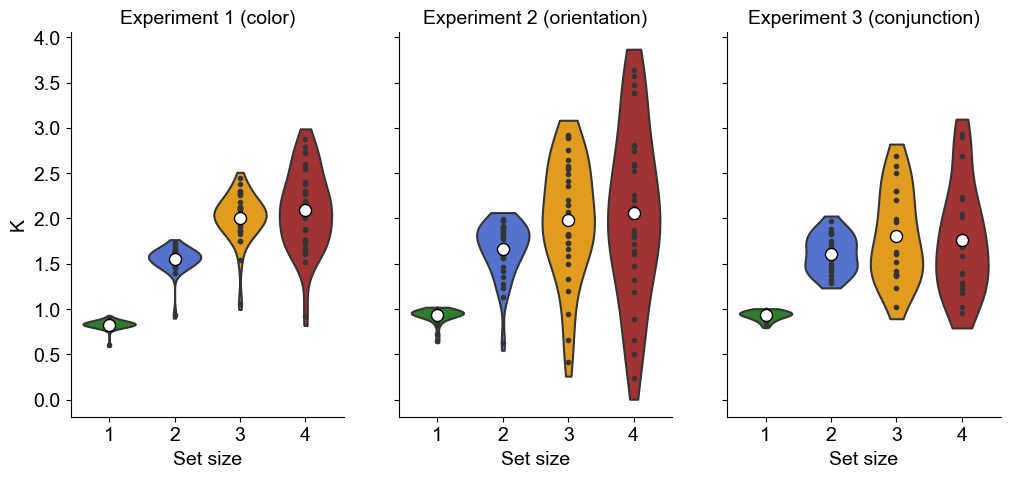

In [15]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12,5))
# fig.suptitle('Change detection K',fontsize=18)
my_pal = {"royalblue", "firebrick", "forestgreen", "orange"}

# experiment 1
sns.violinplot(
    ax = axes[0], 
    x='Set size',y='K', 
    data=df[df['Experiment']==0],
    dodge=True,inner='points',cut=.5,palette = my_pal,scale='width')

axes[0].set_title('Experiment 1 (color)',fontsize=14)

# experiment 2
sns.violinplot(
    ax = axes[1], 
    x='Set size',y='K', 
    data=df[df['Experiment']==1],
    dodge=True,inner='points',cut=.5,palette = my_pal,scale='width') 

axes[1].set_title('Experiment 2 (orientation)',fontsize=14)

# experiment 3
sns.violinplot(
    ax = axes[2], 
    x='Set size',y='K', 
    data=df[df['Experiment']==2],
    dodge=True,inner='points',cut=.5,palette = my_pal,scale='width') 

axes[2].set_title('Experiment 3 (conjunction)',fontsize=14)

for iax,ax in enumerate(axes):

    # plot means
    ax.scatter(
        x = [0,1,2,3],
        y = [total_means[iax][1],total_means[iax][2],total_means[iax][3],total_means[iax][4]],
        c = 'white', edgecolors='k',s=75)

    # asethetics
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.set_xlabel('Set size',fontsize=14)
    if iax == 0:
        ax.set_ylabel('K',fontsize=14)
    else:
        ax.set_ylabel('')
# plt.savefig('output/figures/cd_k.png',dpi=500,bbox_inches='tight')
# plt.savefig('output/figures/cd_k.pdf',dpi=500,bbox_inches='tight')
plt.show()

# Single feature versus conjuncion, within-subject

In [16]:
# Experiment setup
experiment_name1 = '1801'
experiment_name2 = '1901'
experiment_name3 = '1902'
data_dir1 = f'./data/{experiment_name1}'
data_dir2 = f'./data/{experiment_name2}'
data_dir3 = f'./data/{experiment_name3}'

exp1 = decode_eeg.Experiment(experiment_name1,data_dir1)
exp2 = decode_eeg.Experiment(experiment_name2,data_dir2)
exp3 = decode_eeg.Experiment(experiment_name3,data_dir3)

In [17]:
# dummy paramets to setup wrangler for experiment syncer
wrangl = decode_eeg.Wrangler(exp1.info['times'],1,2,1,1,{})

# syncer lets us only load subjects who completed all 3 experiments
sync = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2,exp3],
                                    wrangler = wrangl,
                                    train_group = [experiment_name1,experiment_name2])

In [18]:
ss_acc = []
exp_list = []
ss_list = []
sub_list = []
for isub,sub in enumerate(sync.matched_ids):
    beh = sync.load_behavior(sub)
    for iexp,exp in enumerate(['1801','1901','1902']):
        exp_beh = pd.DataFrame(beh[exp])
        ss_acc.append(list(exp_beh.groupby('SetSize')['ACC'].mean()))
        exp_list.append([iexp]*4)
        ss_list.append([1,2,3,4])
    sub_list.append([isub]*12)

df = pd.DataFrame()
df['acc'] = np.concatenate(ss_acc)
df['exp'] = np.concatenate(exp_list)
df['feat'] = (df['exp'] > 1).astype(int)
df['setsize'] = np.concatenate(ss_list)
df['subject'] = np.concatenate(sub_list)
df

,acc,exp,feat,setsize,subject
0,0.916877,0,0,1,0
1,0.900744,0,0,2,0
2,0.863184,0,0,3,0
3,0.824121,0,0,4,0
4,0.988981,1,0,1,0
...,...,...,...,...,...
235,0.702065,1,0,4,19
236,0.966997,2,1,1,19
237,0.924342,2,1,2,19
238,0.804560,2,1,3,19


In [19]:
from statsmodels.stats.anova import AnovaRM
aovrm = AnovaRM(df, 'acc', 'subject', within=['feat','setsize'],aggregate_func='mean')
res = aovrm.fit()
print(res)

                   Anova
             F Value  Num DF  Den DF Pr > F
-------------------------------------------
feat           4.0922 1.0000 19.0000 0.0574
setsize      213.3000 3.0000 57.0000 0.0000
feat:setsize  17.6864 3.0000 57.0000 0.0000



In [20]:
df_feat = df.groupby(['feat','setsize','subject']).mean().reset_index()
tests_results = pd.DataFrame()
for i,ss in enumerate(df_feat['setsize'].unique()):
    
    df_feat_ss = df_feat[df_feat['setsize']==ss]
    
    tests_results = tests_results.append(pingouin.ttest(
        df_feat_ss[df_feat_ss['feat']==0]['acc'],
        df_feat_ss[df_feat_ss['feat']==1]['acc'],
        paired=True))

_,tests_results['p-val_corrected'],_,_ = statsmodels.stats.multitest.multipletests(tests_results['p-val'],method='fdr_bh')
tests_results

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,p-val_corrected
T-test,-5.280954,19,two-sided,0.000043,"[-0.04, -0.02]",0.955066,596.547,0.981548,0.000170
T-test,0.008389,19,two-sided,0.993394,"[-0.02, 0.02]",0.001427,0.232,0.050004,0.993394
T-test,3.175354,19,two-sided,0.004982,"[0.01, 0.06]",0.514358,9.201,0.588313,0.006642
T-test,3.809217,19,two-sided,0.001185,"[0.02, 0.06]",0.553244,31.565,0.650948,0.002369


In [27]:
print(df_feat.groupby(['feat','setsize']).mean()['acc'])
print(df_feat.groupby(['feat','setsize']).std()['acc'])

feat  setsize
0     1          0.940021
      2          0.902832
      3          0.837850
      4          0.764374
1     1          0.965957
      2          0.902765
      3          0.800773
      4          0.722885
Name: acc, dtype: float64
feat  setsize
0     1          0.030076
      2          0.043103
      3          0.060578
      4          0.075765
1     1          0.023881
      2          0.050946
      3          0.081993
      4          0.074211
Name: acc, dtype: float64


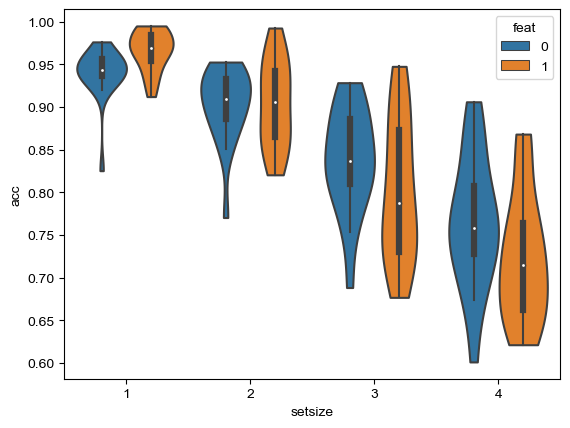

In [21]:
ss_means = df.groupby(['feat','setsize','subject']).mean().reset_index()
sns.violinplot(x='setsize',y='acc',hue='feat',data=ss_means,cut=0)
plt.show()